# Train SPY Model
This notebook will develop and train a neural network to predict the percent change in the SPY price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [1]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
tickr = 'SPY'

In [3]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [4]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on 4 GPUs!


In [5]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [6]:
df = df[:-1]

In [7]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0.949279,1.092841,0.885922,0.483805,-0.772733,-0.466872,15.793173,-0.191622,1.517787,6.430066,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-02,-1.022547,1.090539,0.875679,0.125877,-1.538851,-0.360911,4.861710,0.662265,1.665857,6.378280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-03,-1.162070,1.086009,0.860264,-0.351274,-3.525325,-0.459541,-7.712465,-0.975975,-2.004725,6.378280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-04,-0.250367,1.084532,0.836672,-0.432119,-6.130321,-0.804428,-17.046461,-4.852911,-3.466472,6.378280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-05,0.955671,1.089413,0.856277,-0.215809,-1.483983,-0.591719,2.486295,-5.125757,0.427942,6.499417,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-08,0.220398,1.085024,0.840414,-0.549164,-2.125184,-0.456910,12.409825,-3.034733,1.896197,6.466030,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-09,0.855059,1.084167,0.855052,-0.683315,0.388259,-0.192262,5.140479,-0.726097,0.850453,6.561296,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-10,0.537282,1.083617,0.869200,-0.723398,1.271508,0.059047,2.630468,0.708215,2.002157,6.603423,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-03-11,-0.103631,1.083331,0.880299,-0.745656,2.299737,0.063845,7.384731,1.969541,1.337118,6.672469,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 47s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 19s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 22s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 29s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 41s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 50s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 24s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 30s
Iteration: 11 |periods: 40|hidden: 50|layers: 2

Training complete in 0m 21s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 25s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 30s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 42s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 52s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 21s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 25s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 32s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 44s
Iteration: 90 |periods: 60|hidden

Training complete in 0m 23s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 30s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 42s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 56s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 16s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 20s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 26s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 36s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 55s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 1m 15s
Iteration: 169 |periods: 1

Training complete in 0m 32s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 50s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 8s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 20s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 24s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 34s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 54s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 11s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 16s
Iteration: 248 |periods: 5|hid

Training complete in 0m 34s
Iteration: 317 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 53s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 11s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 16s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 21s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 27s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 38s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 0s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 21s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 14s
Iteration: 326 |periods: 5

Training complete in 0m 59s
Iteration: 396 |periods: 60|hidden: 100|layers: 3|drop: 0.25|lr: 0.01|clip: 5
Training complete in 1m 21s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 14s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 15s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 18s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 23s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 35s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 44s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 14s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 15s
Iteration: 405 |periods: 10|hidden: 50

Training complete in 0m 35s
Iteration: 474 |periods: 60|hidden: 10|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 45s
Iteration: 475 |periods: 1|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 14s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 17s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 20s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 25s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 35s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 46s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 15s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 18s
Iteration: 

Training complete in 0m 35s
Iteration: 552 |periods: 60|hidden: 50|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 46s
Iteration: 553 |periods: 1|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 14s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 18s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 22s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 28s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 39s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 52s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 19s
Iteration: 561 |periods: 

Training complete in 0m 34s
Iteration: 630 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 44s
Iteration: 631 |periods: 1|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 632 |periods: 5|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 18s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 26s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 40s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 54s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 11s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 15s
Iteration: 639 |periods: 10|hi

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

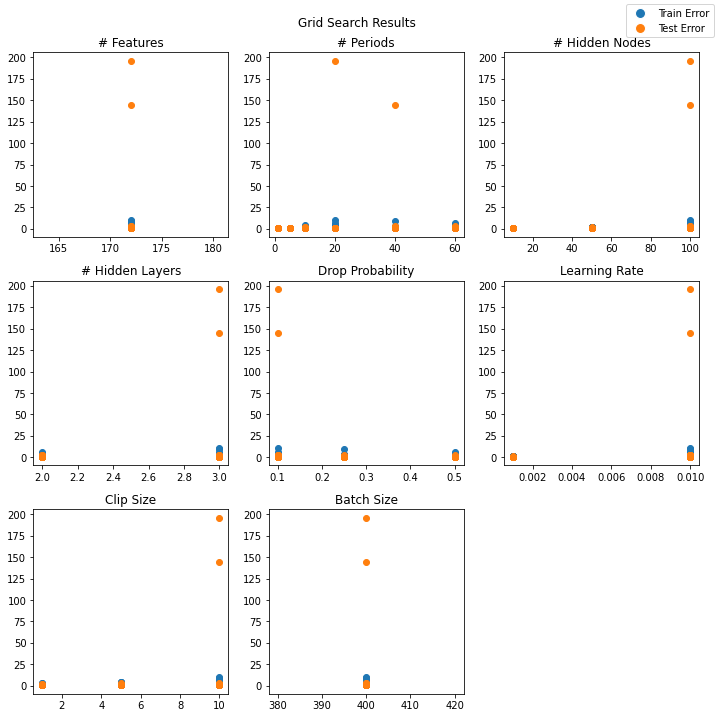

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
111,1.226963,0.337954,172.0,20.0,10.0,2.0,0.10,0.010,1.0,400.0
66,1.266001,0.377282,172.0,1.0,100.0,3.0,0.25,0.001,1.0,400.0
358,1.572702,0.379921,172.0,40.0,100.0,3.0,0.10,0.010,5.0,400.0
443,1.191984,0.386525,172.0,60.0,50.0,2.0,0.10,0.001,10.0,400.0
483,1.220500,0.387342,172.0,20.0,100.0,2.0,0.25,0.001,10.0,400.0
...,...,...,...,...,...,...,...,...,...,...
122,1.691367,2.379515,172.0,10.0,100.0,2.0,0.10,0.010,1.0,400.0
557,6.658329,2.647353,172.0,60.0,100.0,2.0,0.10,0.010,10.0,400.0
430,1.921503,2.679751,172.0,40.0,100.0,3.0,0.50,0.010,5.0,400.0
574,1.678157,144.581726,172.0,40.0,100.0,3.0,0.10,0.010,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [19]:
batch_size = [20,40,80,240,480,960]
epochs = [25,50,100,250,500]

In [20]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 30 different configurations.
Iteration: 1 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 13m 20s
Iteration: 2 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 6m 4s
Iteration: 3 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 2m 59s
Iteration: 4 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 1m 4s
Iteration: 5 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 0m 36s
Iteration: 6 |epochs: 25|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 0m 20s
Iteration: 7 |epochs: 50|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 27m 13s
Iteration: 8 |epochs: 50|periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 1
Training complete in 12m 56s
Iteration: 9 |epochs: 50|periods: 20

In [21]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

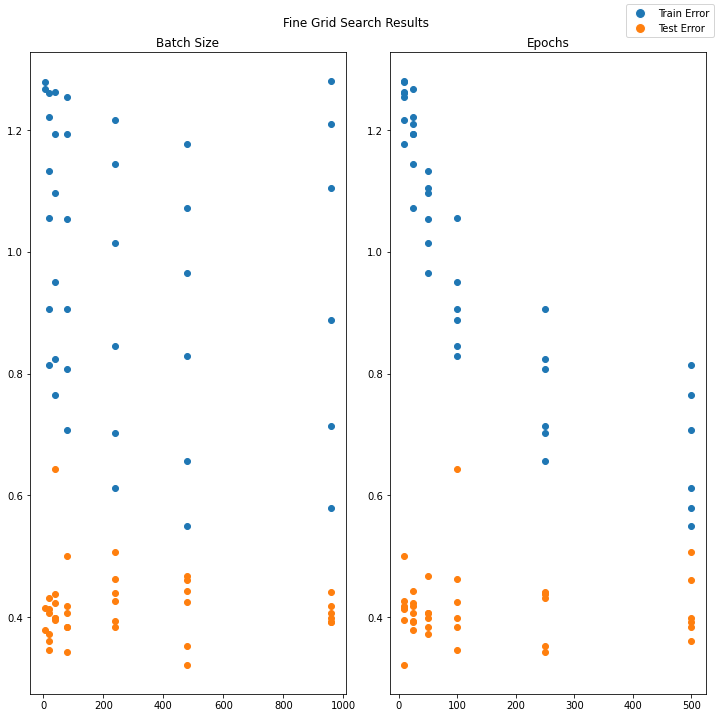

In [22]:
dh.visualizeFineGridSearch(fine_grid_result)

In [23]:
resultdf = dh.resultDFFine(fine_grid_result)

In [24]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
5,1.177771,0.322177,172.0,20.0,10.0,2.0,0.1,0.01,1.0,480.0,10.0
28,0.808071,0.342636,172.0,20.0,10.0,2.0,0.1,0.01,1.0,80.0,250.0
20,1.055086,0.346252,172.0,20.0,10.0,2.0,0.1,0.01,1.0,20.0,100.0
30,0.656901,0.353302,172.0,20.0,10.0,2.0,0.1,0.01,1.0,480.0,250.0
32,0.814037,0.360962,172.0,20.0,10.0,2.0,0.1,0.01,1.0,20.0,500.0
14,1.133467,0.372380,172.0,20.0,10.0,2.0,0.1,0.01,1.0,20.0,50.0
7,1.267986,0.378874,172.0,20.0,10.0,2.0,0.1,0.01,1.0,4.0,25.0
34,0.707783,0.383936,172.0,20.0,10.0,2.0,0.1,0.01,1.0,80.0,500.0
17,1.014146,0.384200,172.0,20.0,10.0,2.0,0.1,0.01,1.0,240.0,50.0
22,0.906207,0.384211,172.0,20.0,10.0,2.0,0.1,0.01,1.0,80.0,100.0


## Evaluate Final Model

In [25]:
best_model_id = sorted_results.index[0]
with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=200, out_features=1, bias=True)
)

Training RMSE: 1.8180313578096534
Test RMSE: 2.591736323224661
Training MAE: 1.1855010655756926
Test MAE: 2.0843624497879074
Training - Above Error: $1.17 (53.35%) Below Error: $-1.21 (46.65%)
Test - Above Error: $1.94 (54.05%) Below Error: $-2.25 (45.95%)


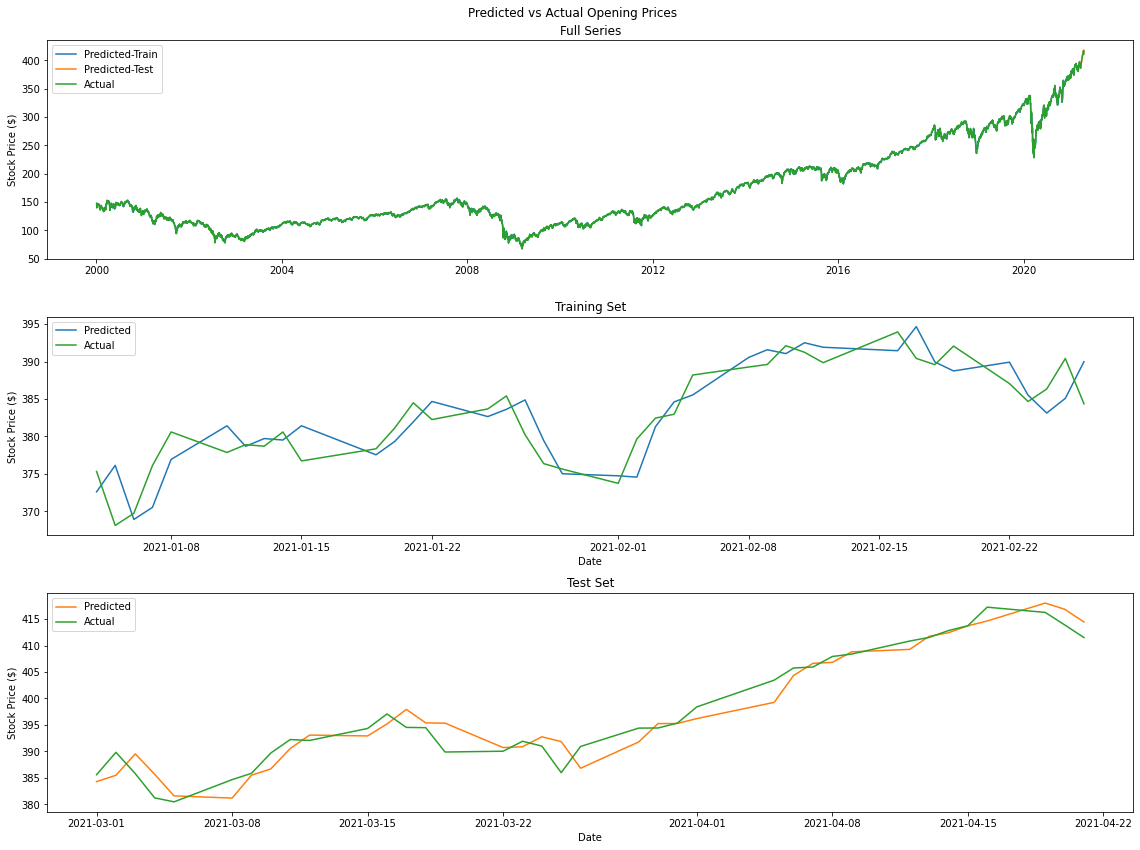

In [26]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [27]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,413.739990,0.002164,Test,413.723346
2021-04-16,417.250000,0.001859,Test,414.635318
2021-04-19,416.260010,0.001449,Test,418.025750
2021-04-20,413.910004,0.001312,Test,416.863114
2021-04-21,411.510010,0.000701,Test,414.453054


In [28]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [29]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)